# Homework 1

秦思淼 22210980066

# Question 1

# 数据读取与预处理

首先，导入相关包。

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from datetime import datetime
from numpy import array
import cvxpy as cp

然后读取数据并对数据进行预处理，因为数据是根据日期逆序排列，所以需要对dataframe逆序读取得到日期正序的数据，同时注意到某些股票在一些日期的价格是空值，这里采取前一天的数据替换空值，当作当天的股票价格。

In [2]:
data = pd.read_csv('his_close_price.csv',encoding = 'gbk')
data = data.iloc[::-1]
data

,trade_date,沪深300,600999.SH,601001.SH,601002.SH,601003.SH,601005.SH,601006.SH,601007.SH,601008.SH,...,601898.SH,601899.SH,601918.SH,601919.SH,601939.SH,601958.SH,601988.SH,601989.SH,601991.SH,601998.SH
2916,20100104,3535.23,44.78,7.95,8.38,5.75,10.21,8.47,7.79,18.87,...,9.62,17.84,13.71,6.12,18.81,4.29,7.63,8.96,8.07,NaN
2915,20100105,3564.04,30.85,46.54,8.09,8.31,5.78,10.16,8.47,7.91,...,13.97,9.82,18.53,14.07,6.21,19.53,4.34,7.60,9.18,8.17
2914,20100106,3541.73,30.16,47.21,7.90,8.68,5.82,10.17,8.42,7.77,...,14.10,9.68,18.47,14.10,6.11,19.45,4.29,7.69,9.15,7.94
2913,20100107,3471.46,29.91,46.27,7.62,8.49,5.67,9.95,8.25,7.54,...,13.72,9.51,17.83,13.68,6.02,19.29,4.21,7.60,8.94,7.67
2912,20100108,3480.13,30.53,45.20,7.72,8.34,5.94,9.94,8.32,7.59,...,13.81,9.43,17.51,13.62,6.04,18.88,4.23,7.52,8.89,7.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,20211227,4919.32,17.30,10.41,5.09,5.23,2.11,6.35,5.64,3.87,...,6.62,9.58,4.79,18.70,5.87,6.80,3.06,4.16,3.39,4.59
3,20211228,4955.96,17.38,9.90,5.09,5.22,2.08,6.32,5.65,3.89,...,6.40,9.71,4.60,19.60,5.91,6.83,3.07,4.17,3.25,4.62
2,20211229,4883.48,17.26,9.75,5.09,5.23,2.08,6.32,5.71,3.92,...,6.37,9.62,4.66,19.45,5.87,6.82,3.05,4.21,3.15,4.63
1,20211230,4921.51,17.53,9.66,5.05,5.23,2.07,6.38,5.73,3.89,...,6.36,9.64,4.60,18.70,5.87,6.82,3.05,4.22,3.20,4.61


In [3]:
trade_date = []
HS300 = []
HS300_return = []
stock_name = []    # 股票名称
stock_price = []   #股票价格
stock_return = []  #股票收益率

# 载入数据
for i in range(2,len(data.columns)):
    stock_name.append(data.columns[i])
for i in range(len(data)):
    date = str(int(data.iloc[i][0]))
    trade_date.append(datetime(int(date[:4]),int(date[4:6]),int(date[6:])))
    HS300.append(data.iloc[i][1])
    stock_price.append(data.iloc[i][2:].to_numpy()) #这里股票价格有点问题，有一些值是NAN，需要处理一下
    for j in range(len(stock_name)):
        if np.isnan(stock_price[i][j]):
            stock_price[i][j] = stock_price[i-1][j] if i else data.iloc[i+1][j+2]
            

In [4]:
#检查是否还有NAN
n = 0
for i in range(len(data)):
    for j in range(len(stock_name)):
        n += int(np.isnan(stock_price[i][j]))
n

0

In [5]:
stock_price = np.array(stock_price)

接下来计算return

In [6]:
#为了对齐,添加全1行，这样return[i]表示的是trade_date[i]当天收益率
HS300_return.append(1)
stock_return.append(np.ones(len(stock_name)))
for i in range(1,len(data)):
    stock_return.append([np.log(stock_price[i][j]/stock_price[i-1][j]) for j in range(len(stock_name))])
    HS300_return.append(np.log(HS300[i]/HS300[i-1]))

In [7]:
stock_return = np.array(stock_return)

# Sliding window

compared_date是为了辅助找出trade_date里每隔四个月的第一天

In [8]:
compared_date = [[datetime(2010,1,1),datetime(2015,1,1)]]
while True:
    date = compared_date[-1][-1]
    year = date.year
    month = date.month
    month += 4
    if month > 12:
        month -= 12
        year += 1
    new_date = [datetime(year-5,month,1),datetime(year, month, 1)]
    if new_date[-1] > trade_date[-1]:
        break
    compared_date.append(new_date)

In [9]:
def sliding_window(compared_date):
    start_index = end_index = 1
    for s,e in compared_date:
        while trade_date[start_index] < s:
            start_index += 1
        while trade_date[end_index] < e:
            end_index += 1
        yield (start_index, end_index) 
        #trade_date[end_index]是计算最优投资组合的交易日，trade_date[start_index]是五年前开始估算均值与方差的时间
    

In [10]:
runner = sliding_window(compared_date)
adjust_index = []
adjust_date = []
compute_period = []
for s,e in runner:
    adjust_index.append(e)
    adjust_date.append(trade_date[e])
    compute_period.append([s,e])

# 一些工具函数

In [11]:
def get_expected_returns(returns):
    return np.mean(returns, axis = 0)

In [12]:
def get_cov(returns):
    return np.cov(returns, y = None, rowvar = False)

In [13]:
def Bestportfolio(returns):
    n = len(returns[0]) + 1
    expected_r = 0.06/252
    riskless_r = 0.03/252
    expected_returns = get_expected_returns(returns)
    Sigma = get_cov(returns) # 50*50
    r = np.array(np.append(riskless_r, expected_returns))
    
    w = cp.Variable(n) # 第0维是无风险占的比例,一共51维
    objective = cp.Minimize(1/2 * cp.quad_form(w[1:], Sigma))
    constraints = [w.T @ r == expected_r, cp.sum(w) == 1]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    return w.value

假设无风险不加入投资组合

In [14]:
def ignore_riskless(returns):
    n = len(returns[0])
    expected_r = 0.06/252
    r = get_expected_returns(returns)
    Sigma = get_cov(returns) # 50*50
    
    w = cp.Variable(n) # 50维
    objective = cp.Minimize(1/2 * cp.quad_form(w, Sigma))
    constraints = [w.T @ r == expected_r, cp.sum(w) == 1]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    return w.value
    

In [15]:
def next_period_returns(w, index_s, index_e):
    portfolio_returns = []
    r0 = 0.03/252
    for i in range(index_s + 1, index_e + 1): # trade_date[index_s]这一天更改投资组合，收益率从下一天算起
        daily_returns = stock_return[i]
        portfolio_returns.append(w.T[1:] @ daily_returns + w[0]*r0)
    return portfolio_returns

In [16]:
def next_period_returns2(w, index_s, index_e):
    portfolio_returns = []
    for i in range(index_s + 1, index_e + 1): # trade_date[index_s]这一天更改投资组合，收益率从下一天算起
        daily_returns = stock_return[i]
        portfolio_returns.append(w.T @ daily_returns)
    return portfolio_returns

In [17]:
portfolio_returns = []
portfolio_returns2 = []
for i in range(len(adjust_index)-1):
    returns = stock_return[compute_period[i][0]:compute_period[i][1]+1]
    w = Bestportfolio(returns)
    w2 = ignore_riskless(returns)
    portfolio_returns.extend(next_period_returns(w,adjust_index[i],adjust_index[i+1]))
    portfolio_returns2.extend(next_period_returns2(w2,adjust_index[i],adjust_index[i+1]))
returns = stock_return[compute_period[-1][0]:compute_period[-1][1]+1]
w = Bestportfolio(returns)
w2 = ignore_riskless(returns)
portfolio_returns.extend(next_period_returns(w,adjust_index[-1],len(stock_return)-1))
portfolio_returns2.extend(next_period_returns2(w2,adjust_index[-1],len(stock_return)-1))

In [18]:
running_dates = trade_date[adjust_index[0]:]

In [19]:
asset_price = lambda l : [1 + sum(l[:i+1]) for i in range(len(l))]

In [20]:
running_HS300 = asset_price(HS300_return[adjust_index[0]+1:])
running_portfolio = asset_price(portfolio_returns)
running_portfolio2 = asset_price(portfolio_returns2)
running_HS300 = [1]+running_HS300
running_portfolio = [1] + running_portfolio
running_portfolio2 = [1] + running_portfolio2
print(running_portfolio[-1])

1.0485320687873634


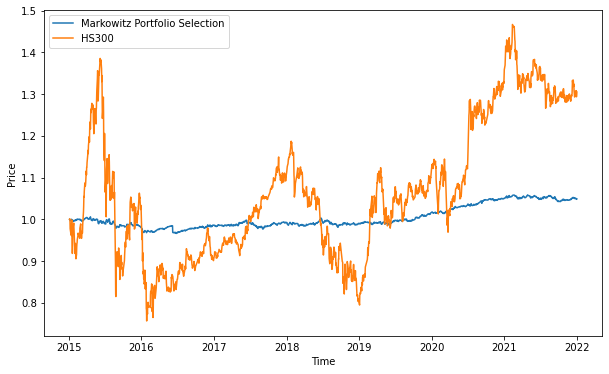

In [21]:
plt.figure(figsize=(10,6))
plt.plot(running_dates, running_portfolio, label="Markowitz Portfolio Selection")
plt.plot(running_dates, running_HS300, label="HS300")
plt.legend()
plt.xlabel('Time')
plt.ylabel('Price')
axis = plt.gca()
plt.show()

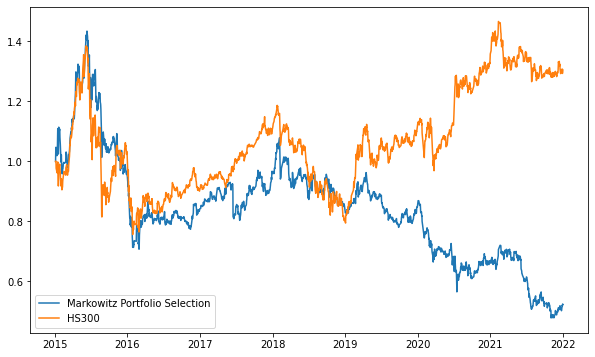

In [22]:
plt.figure(figsize=(10,6))
plt.plot(running_dates, running_portfolio2, label="Markowitz Portfolio Selection")
plt.plot(running_dates, running_HS300, label="HS300")
plt.legend()
axis = plt.gca()
plt.show()

# Question 2

从之前计算好的return矩阵中随机取6列，做线性回归，从而得到beta值和alpha值，并对alpha = 0 做假设检验，计算其p值，与0.05比较

In [23]:
import statsmodels.api as sm

随机取6个index,改变随机种子获得不同的数

In [24]:
np.random.seed(888)
ls = list(range(stock_return.shape[-1]))
indices = list(np.random.choice(ls, size = 6,replace = False))
indices.sort()


In [25]:
new_return = []
new_name = []
for i in indices:
    new_return.append(stock_return[:,i])
    new_name.append(stock_name[i])

In [26]:
new_return = np.array(new_return).T
HS300_return = np.array(HS300_return)
r0 = 0.06/252
x = HS300_return - r0
x = sm.add_constant(x)
Y = new_return - r0

In [27]:
Y.shape

(2917, 6)

In [28]:
models = []
for i in range(6):
    model = sm.OLS(Y[:,i],x).fit()
    models.append(model)

打印结果

In [29]:
res = pd.DataFrame([], columns=['code', 'alpha', 'beta', 'p-value for alpha=0','reject'])
for i in range(len(models)):
    model = models[i]
    name = new_name[i]
    res.loc[len(res)] = [name, model.params[0], model.params[1], model.pvalues[0], model.pvalues[0] < 0.05]
res

,code,alpha,beta,p-value for alpha=0,reject
0,601006.SH,-0.000189,0.898469,0.459831,False
1,601107.SH,-0.000302,0.966669,0.365968,False
2,601168.SH,-0.000241,1.072155,0.518450,False
3,601601.SH,0.000106,1.032240,0.767262,False
4,601618.SH,-0.000823,0.958837,0.235810,False
5,601628.SH,-0.000135,1.024329,0.652241,False


#  Question 3

首先，根据给出的数据计算二叉树所需要的参数，然后计算价格树，然后就可以迭代计算期权价格了

In [30]:
k = 40
price_tree = {} # （i,j）-> price，其中i是上升的步数，j是下
p0 = 40 # 初始价格
r0 = 0.03 #无风险利率
T = 1.5 #18个月等于1.5年
sigma = 0.4 # stock volatility

In [31]:
def get_u_d(n):
    u = np.exp(sigma*np.sqrt(T/n))
    d = 1/u
    return u,d

In [32]:
def get_p(u,d,n):
    a = np.exp(r0*T/n)
    return (a - d)/(u - d)

In [33]:
def price(n,u,d):
    price_tree = {(0,0):p0}
    for steps in range(1, n+1):
        for i in range(0, steps+1):
            j = steps - i
            price_tree[(i,j)] = p0 * np.power(u,i-j)
    return price_tree

In [34]:
def get_put_price(price_tree, n, p):
    put_price_tree = {}
    a = np.exp(r0*T/n)
    for i in range(n+1):
        j = n - i
        put_price_tree[(i,j)] = max(k-price_tree[(i,j)],0)
    for num in range(n-1,-1,-1):
        for i in range(num+1):
            j = num - i
            put_price_tree[(i,j)] = (p*put_price_tree[(i+1,j)] + (1-p)*put_price_tree[(i,j+1)])/a
    return put_price_tree[(0,0)]
        

In [35]:
put_price_l = []
for n in range(1,101):
    u,d = get_u_d(n)
    p = get_p(u,d,n)
    price_tree = price(n,u,d)
    put_price_l.append(get_put_price(price_tree,n,p))

In [36]:
print(put_price_l[9],put_price_l[49],put_price_l[99])

6.533834281660009 6.6832059975991625 6.702124331429693


In [37]:
# Black-Scholes
from scipy.stats import norm
d_1 = (np.log(p0/k) + (r0 + sigma*sigma/2)*T)/(sigma * np.sqrt(T))
d_2 = d_1 - sigma*np.sqrt(T)
black_scholes_price = k*np.exp(-r0*T)*norm.cdf(-d_2) - p0*norm.cdf(-d_1)
print(black_scholes_price)

6.721091884244682


Text(0, 0.5, 'Option Price')

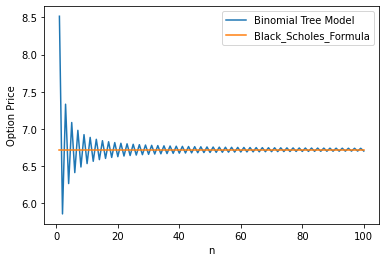

In [38]:
b_p = [black_scholes_price]*100
plt.plot(range(1,101),put_price_l,label = 'Binomial Tree Model')
plt.plot(range(1,101),b_p, label = 'Black_Scholes_Formula')
plt.legend()
plt.xlabel('n')
plt.ylabel('Option Price')

In [39]:
def get_put_price2(price_tree, n, p):
    put_price_tree = {}
    a = np.exp(r0*T/n)
    for i in range(n+1):
        j = n - i
        put_price_tree[(i,j)] = max(k-price_tree[(i,j)],0)
    for num in range(n-1,-1,-1):
        for i in range(num+1):
            j = num - i
            p1 = (p*put_price_tree[(i+1,j)] + (1-p)*put_price_tree[(i,j+1)])/a
            p2 = max(k-price_tree[(i,j)],0)
            put_price_tree[(i,j)] = max(p1,p2)
    return put_price_tree[(0,0)]
        

In [40]:
put_price_l2 = []
for n in range(1,101):
    u,d = get_u_d(n)
    p = get_p(u,d,n)
    price_tree = price(n,u,d)
    put_price_l2.append(get_put_price2(price_tree,n,p))

Text(0, 0.5, 'Option Price')

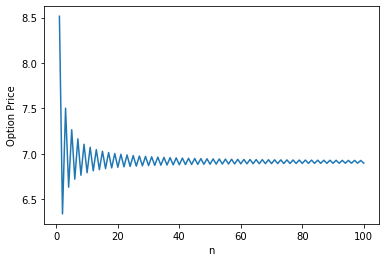

In [41]:
plt.plot(range(1,101),put_price_l2)
plt.xlabel('n')
plt.ylabel('Option Price')

In [42]:
put_price_l2[-1]

6.897469827663956